In [1]:
# Import packages
suppressPackageStartupMessages({
    library(ggpubr)
    library(rstatix)
    library(readr)
    library(dplyr)
    library(magrittr)
    library(data.table)
    library(tibble)
    library(stringr)
    library(Seurat)
    library(ggplot2)
    library(viridis)
    library(org.Mm.eg.db)
    library(EnsDb.Mmusculus.v79)
    library(TxDb.Mmusculus.UCSC.mm10.ensGene)
    library(tidyr)
    library(reshape2)
    library(ggrepel)
    library(purrr)
    library(patchwork)
    library(ggridges)
options(stringsAsFactors = FALSE)
})

In [2]:
# Set dplyr as default function for select, filter, and rename
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

In [3]:
# Pdf exporting function to maintain naming scheme for filenames
make_pdf <- function(object, filename, w, h){
    out_name <- paste0(format(Sys.Date(), "%y%m%d"),"_",filename,".pdf")
    pdf(out_name, width=w, height=h)
        plot(object)
    dev.off()
}

In [4]:
enrichment <- function(data){
    out <- list()
    df <- as.table(rbind(c(data[[1]], data[[2]]), c(data[[3]], data[[4]])))
    dimnames(df) <- list(genes = c("Upregulated genes", "Not upregulated genes"), test = c("Yes", "No"))
    out[[1]] <- fisher.test(df)
    out[[2]] <- chisq.test(df)
    out[[3]] <- as.data.frame(df) %>% 
        dcast(genes~test) %>% 
        mutate(total=Yes+No, yes_perc=Yes/(Yes+No), no_perc=No/(Yes+No)) %>%
        select(genes, yes_perc, no_perc) %>%
        melt() %>%
        select(-variable) %>%
        mutate(genes_factor=factor(.$genes, levels=c("Not upregulated genes", "Upregulated genes")))
    return(out)
}

In [5]:
enrichment_barplot <- function(df, title, lim){
    out <- ggplot(df, aes(x=genes_factor, fill=genes_factor, y=value*100)) +
        geom_bar(stat="identity", color="black", width=1) +
        facet_wrap(~genes_factor, strip.position="bottom", scales="free_x") +
        scale_fill_manual(values=c("#77AADB", "#ee8866")) +
        ggtitle(title) +
        ylab(NULL) +
        xlab(NULL) +
        coord_cartesian(clip="off") +
        scale_x_discrete(labels=c("n=327", "n=72")) +
        scale_y_continuous(labels = function(x){paste0(x, "%")}, expand=c(0,0), limits = c(0, lim)) +
        theme(panel.grid=element_blank(),
              panel.background=element_blank(),
              axis.title.y=element_text(color="black", size=7),
              axis.text.y=element_text(color="black", size=7),
              axis.text.x=element_text(color="black", size=7, margin=margin(t=0, b=0)),
              legend.title=element_text(size=7, hjust=0.5),
              axis.ticks=element_blank(),
              axis.line.x=element_blank(),
              legend.text=element_text(size=7),
              legend.position="none",
              plot.title=element_text(size=7, hjust=0.5),
              strip.background = element_blank(),
              strip.placement = "outside",
              strip.text.x = element_text(color="black", angle=90, size=7, hjust=1, vjust=0.5, margin=margin(t=0)),
              panel.spacing = unit(0, "lines"))    
    return(out)
}  

In [6]:
# Palette setup 
myPalette <- list("#77270d", "#ee8866", "#d6c941", "#eedd88", "#aaaa00", "#4ed641", "#44bb99", "#41d6c9", "#414ed6", "#77aadd", "#c941d6","#ffaabb")
names(myPalette) <- c("bold_red", "red", "bold_yellow", "yellow", "bold_green", "green", "bold_cyan", "cyan", "bold_blue", "blue", "bold_magenta", "magenta")

In [7]:
# Set working directory
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/beatrice_data")

In [8]:
# Import gene metadata from EnsDb.Mmusculus.v79 package
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

# Import deletion metadata
metadata <- data.frame(dox = c(TRUE, TRUE, TRUE,
                               FALSE, FALSE, FALSE),
                       sample_name = c("d3_dox_1", "d3_dox_2", "d3_dox_3",
                                       "d3_nodox_1", "d3_nodox_2", "d3_nodox_3"),
                       rep = c(1, 2, 3, 1, 2, 3),
                       sample_id = c("SRX4650425", "SRX4650426", "SRX4650427", 
                                     "SRX4650422", "SRX4650423", "SRX4650424"),
                       sample = c(rep("d3_dox", 3), rep("d3_nodox", 3)))


bulk_mus_TPM <- read.table("231002_bulk_mus_TPM_chr3.csv", header=TRUE, sep=",")
bulk_cast_TPM <- read.table("231002_bulk_cast_TPM_chr3.csv", header=TRUE, sep=",")

'select()' returned 1:1 mapping between keys and columns



In [9]:
# Reformat the TPM counts to include the following columns: GENEID, sample, cell_type, rep, Cast, Mus, SYMBOL, GENESEQSTART, GENESEQEND, CDSCHROM
bulk_TPM <- rownames_to_column(bulk_mus_TPM, "SYMBOL") %>% 
    left_join(rownames_to_column(bulk_cast_TPM, "SYMBOL")) %>% # Combine Mus and Cast counts
    melt() %>%
    mutate(temp = gsub(pattern="Chr3_Xist_[nodx]{3,5}_d3_(SRX[0-9]{7})_([0-9])_TPM", replacement="\\1_\\2", .$variable)) %>% # Use some regex to generate "sample" column
    separate(temp, into=c("sample_id", "allele")) %>%
    left_join(metadata) %>%
    mutate(allele=case_when( #Ensure that the alleles follow the same naming scheme
        allele==1 ~ "Mus",
        allele==2 ~ "Cast",
        TRUE ~ allele)) %>%
    dcast(formula = SYMBOL+sample_id+dox+sample_name+rep+sample~allele, value.var = "value") %>% # Perform the actual reformatting
    left_join(gene_metadata[,c("SYMBOL", "CDSCHROM")])

Joining, by = "SYMBOL"
Using SYMBOL as id variables

Joining, by = "sample_id"
Joining, by = "SYMBOL"


In [10]:
bulk_TPM$sample_name <- factor(bulk_TPM$sample_name)

In [11]:
bulk_TPM <- bulk_TPM %>% filter(CDSCHROM %in% lapply(c(1:19, "X"), function(x){paste0("chr", x)}))

In [12]:
quantile(bulk_TPM$Cast, c(0,0.05, 0.95))
quantile(bulk_TPM$Mus, c(0,0.05, 0.95))
quantile(bulk_TPM$Cast, c(0,0.10, 0.90))
quantile(bulk_TPM$Mus, c(0,0.10, 0.90))

0%       5%      95% 
  0.0000   0.0000 122.7953

0%       5%      95% 
 0.00000  0.00000 87.59088

0%      10%      90% 
 0.00000  0.00000 74.00663

0%      10%      90% 
 0.00000  0.00000 52.92993

In [13]:
bulk_TPM_full <- bulk_TPM %>% left_join(gene_metadata)

Joining, by = c("SYMBOL", "CDSCHROM")


In [14]:
bulk_TPM_full %>% head
test <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3") %>%
    group_by(sample, GENEID) %>% 
    summarize(meanCast=mean(Cast), meanMus=mean(Mus), GENESEQSTART=unique(GENESEQSTART)) %>% 
    filter(meanCast>0 | meanMus>0)

,SYMBOL,sample_id,dox,sample_name,rep,sample,Cast,Mus,CDSCHROM,GENEID,GENESEQSTART,GENESEQEND
,<chr>,<chr>,<lgl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
1,a,SRX4650422,FALSE,d3_nodox_1,1,d3_nodox,0,0.000000,chr2,ENSMUSG00000027596,154791402,155051012
2,a,SRX4650423,FALSE,d3_nodox_2,2,d3_nodox,0,1.381846,chr2,ENSMUSG00000027596,154791402,155051012
3,a,SRX4650424,FALSE,d3_nodox_3,3,d3_nodox,0,0.000000,chr2,ENSMUSG00000027596,154791402,155051012
4,a,SRX4650425,TRUE,d3_dox_1,1,d3_dox,0,0.000000,chr2,ENSMUSG00000027596,154791402,155051012
5,a,SRX4650426,TRUE,d3_dox_2,2,d3_dox,0,0.000000,chr2,ENSMUSG00000027596,154791402,155051012
6,a,SRX4650427,TRUE,d3_dox_3,3,d3_dox,0,0.000000,chr2,ENSMUSG00000027596,154791402,155051012


`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


In [16]:
chr3_exp_data <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast<quantile(bulk_TPM_full$Cast, c(0.10, 0.90))[[2]], 
           Mus<quantile(bulk_TPM_full$Mus, c(0.10, 0.90))[[2]],
           Cast>quantile(bulk_TPM_full$Cast, c(0.10, 0.90))[[1]], 
           Mus>quantile(bulk_TPM_full$Mus, c(0.10, 0.90))[[1]]) %>%
    group_by(sample, GENEID) %>% 
    summarize(meanCast=mean(Cast), meanMus=mean(Mus), GENESEQSTART=unique(GENESEQSTART)) %>% 
    ungroup() %>%
    select(-GENEID) %>%
    melt(id.vars = c("sample", "GENESEQSTART"))

chr3_exp_data %>% head

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


,sample,GENESEQSTART,variable,value
,<chr>,<int>,<fct>,<dbl>
1,d3_dox,108107280,meanCast,14.0615032
2,d3_dox,116488963,meanCast,18.0528236
3,d3_dox,116513070,meanCast,10.4118586
4,d3_dox,89520164,meanCast,0.2215908
5,d3_dox,90476201,meanCast,51.7318948
6,d3_dox,90488026,meanCast,31.1350006


In [20]:
bulk_TPM_full_chr3_active <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           GENESEQSTART < 80000000,
           Cast>quantile(bulk_TPM$Cast, c(0.05, 0.95))[[1]], 
           Mus>quantile(bulk_TPM$Mus, c(0.05, 0.95))[[1]],
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    group_by(sample_name, sample, dox) %>% 
    summarize(medianCast=mean(Cast),
              medianMus=mean(Mus))
bulk_TPM_full_chr3_inactive <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           GENESEQSTART >= 80000000,
           Cast>quantile(bulk_TPM$Cast, c(0.05, 0.95))[[1]], 
           Mus>quantile(bulk_TPM$Mus, c(0.05, 0.95))[[1]],
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    group_by(sample_name, sample, dox) %>% 
    summarize(medianCast=mean(Cast),
              medianMus=mean(Mus))

`summarise()` has grouped output by 'sample_name', 'sample'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample_name', 'sample'. You can override using the `.groups` argument.


In [21]:
bulk_TPM_full_chr3_inactive$dox_factor <- factor(bulk_TPM_full_chr3_inactive$dox, levels=c(FALSE, TRUE))
bulk_TPM_full_chr3_active$dox_factor <- factor(bulk_TPM_full_chr3_active$dox, levels=c(FALSE, TRUE))
bulk_TPM_full_chr3_inactive$sample_factor <- factor(bulk_TPM_full_chr3_inactive$sample, levels=c("d3_nodox", "d3_dox"))
bulk_TPM_full_chr3_active$sample_factor <- factor(bulk_TPM_full_chr3_active$sample, levels=c("d3_nodox", "d3_dox"))

In [22]:
medMusInactive <- ggplot(bulk_TPM_full_chr3_inactive, aes(x=sample_factor, y=medianMus, fill=dox_factor)) + ylab("Mean normalized expression \n (Mus)")
medCastInactive <- ggplot(bulk_TPM_full_chr3_inactive, aes(x=sample_factor, y=medianCast, fill=dox_factor)) + ylab("Mean normalized expression \n (Cast)")
medMusActive <- ggplot(bulk_TPM_full_chr3_active, aes(x=sample_factor, y=medianMus, fill=dox_factor)) + ylab("Mean normalized expression \n (Mus)")
medCastActive <- ggplot(bulk_TPM_full_chr3_active, aes(x=sample_factor, y=medianCast, fill=dox_factor)) + ylab("Mean normalized expression \n (Cast)")

plots_list <- list(medMusInactive, medCastInactive, medMusActive, medCastActive)
names(plots_list) <- c("medMusInactive","medCastInactive","medMusActive","medCastActive")
for(i in 1:4){
    plots_list[[i]] <- plots_list[[i]] +
        geom_boxplot(color="black") +
        geom_point(shape=21,
                    size=1,
                    stroke=0.25) +
        scale_fill_manual(values=unname(unlist(myPalette[1:4]))) +
        scale_x_discrete(labels=c("-dox", "+dox")) +
        stat_compare_means(method = "t.test",
                           comparisons=list(c("d3_nodox", "d3_dox")),
                           label.y=(max(bulk_TPM_full_chr3_active$medianCast) + 2),
                           label="p.signif",
                           size=7*0.352777778,
                           hjust=0.5,
                           vjust=0,
                           family='sans',
                           tip.length=0.00) +
        ylim(c(0,NA)) +
        xlab("") +
        ggtitle(names(plots_list)[[i]]) +
        theme(panel.grid = element_blank(),
              panel.background = element_blank(),
              axis.line = element_line(color="black"),
              axis.ticks = element_line(color="black"),
              legend.position="none",
              axis.text.y = element_text(size=7, color="black"),
              axis.text.x = element_text(size=7, angle=45, color="black", hjust=1, vjust=1),
              axis.title.y = element_text(size=7, color="black"),
              plot.title = element_text(size=8, color="black"))
}


In [22]:
t.test(x=bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample=="d3_dox"),]$medianCast,
       y=bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample=="d3_nodox"),]$medianCast)
t.test(x=bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample=="d3_dox"),]$medianMus,
       y=bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample=="d3_nodox"),]$medianMus)
t.test(x=bulk_TPM_full_chr3_active[which(bulk_TPM_full_chr3_active$sample=="d3_dox"),]$medianMus,
       y=bulk_TPM_full_chr3_active[which(bulk_TPM_full_chr3_active$sample=="d3_nodox"),]$medianMus)


	Welch Two Sample t-test

data:  bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample == "d3_dox"), ]$medianCast and bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample == "d3_nodox"), ]$medianCast
t = -22.343, df = 2.0342, p-value = 0.001837
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -13.01295  -8.86673
sample estimates:
mean of x mean of y 
 14.58967  25.52951 



	Welch Two Sample t-test

data:  bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample == "d3_dox"), ]$medianMus and bulk_TPM_full_chr3_inactive[which(bulk_TPM_full_chr3_inactive$sample == "d3_nodox"), ]$medianMus
t = 3.5562, df = 3.5684, p-value = 0.02859
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.4889854 4.9269673
sample estimates:
mean of x mean of y 
 19.53043  16.82245 



	Welch Two Sample t-test

data:  bulk_TPM_full_chr3_active[which(bulk_TPM_full_chr3_active$sample == "d3_dox"), ]$medianMus and bulk_TPM_full_chr3_active[which(bulk_TPM_full_chr3_active$sample == "d3_nodox"), ]$medianMus
t = 0.63915, df = 3.6546, p-value = 0.5606
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.685753  5.785407
sample estimates:
mean of x mean of y 
 21.27729  20.22746 


[1] "medMusInactive"  "medCastInactive" "medMusActive"    "medCastActive"

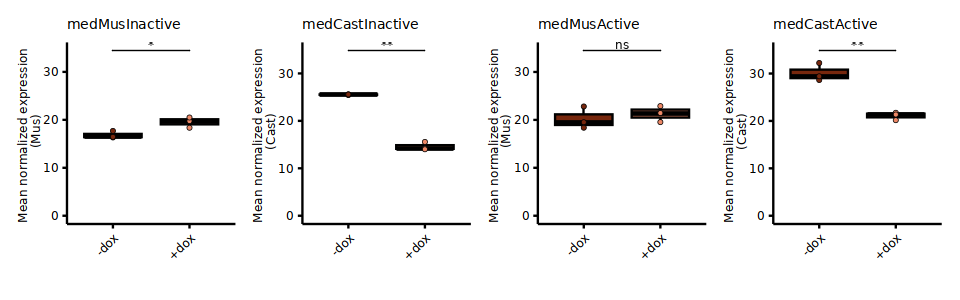

In [123]:
options(repr.plot.width=8, repr.plot.height=2.5)
names(plots_list)
wrap_plots(plots_list, nrow = 1)

[1] "medMusInactive"  "medCastInactive" "medMusActive"    "medCastActive"

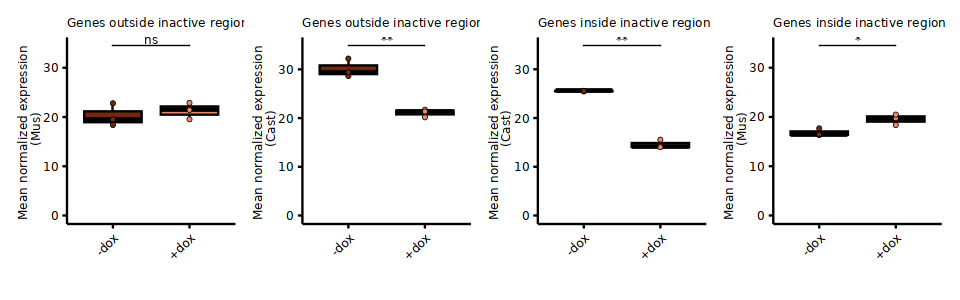

In [125]:
options(repr.plot.width=8, repr.plot.height=2.5)
names(plots_list)
chr3_plots <- wrap_plots(list(plots_list[[3]] + ggtitle("Genes outside inactive region") + theme(plot.title=element_text(size=7)),
                plots_list[[4]] + ggtitle("Genes outside inactive region") + theme(plot.title=element_text(size=7)),
                plots_list[[2]] + ggtitle("Genes inside inactive region") + theme(plot.title=element_text(size=7)),
                plots_list[[1]] + ggtitle("Genes inside inactive region") + theme(plot.title=element_text(size=7))), nrow = 1)
chr3_plots

In [126]:
make_pdf(chr3_plots, "chr3_plots", w=8, h=2.5)

png 
  2

In [22]:
options(repr.plot.width=1.5, repr.plot.height=2.5)
medMusInactive
medCastInactive
medMusActive
medCastActive
make_pdf(plots_list[[1]], "chr3_Mus_inactive_section", w=1.5, h=2.5)
make_pdf(plots_list[[2]], "chr3_Cast_inactive_section", w=1.5, h=2.5)
make_pdf(plots_list[[3]], "chr3_Mus_active_section", w=1.5, h=2.5)
make_pdf(plots_list[[4]], "chr3_Cast_active_section", w=1.5, h=2.5)

png 
  2

png 
  2

png 
  2

png 
  2

In [23]:
chr3_expressed_genes_nodox <- bulk_TPM_full %>% filter(sample=="d3_nodox", CDSCHROM=="chr3") %>% filter(Cast+Mus>5) %>% .$GENEID %>% unique()

In [ ]:
inactivated_genes <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    ungroup() %>%
    group_by(GENEID, sample) %>% 
    summarize(medCast=median(Cast), medMus=median(Mus)) %>% 
    mutate(len=length(GENEID)) %>%
    filter(len==2) %>% 
    select(-len, -medMus) %>% 
    #select(-medMus) %>% 
    melt() %>% 
    select(-variable) %>%
    dcast(GENEID~sample, value.var = "value") %>% 
    filter(d3_dox <= d3_nodox*0.25, GENEID %in% chr3_expressed_genes_nodox)

inactivated_genes %>% head
inactivated_genes %>% nrow()
upregulated_genes <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast>quantile(bulk_TPM$Cast, c(0.05, 0.95))[[1]], 
           Mus>quantile(bulk_TPM$Mus, c(0.05, 0.95))[[1]],
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    mutate(sum_total=Cast+Mus) %>%
    ungroup() %>%
    group_by(GENEID, sample) %>% 
    summarize(medTotal=median(sum_total), medMus=median(Mus)) %>% 
    mutate(len=length(GENEID)) %>% 
    filter(len==2) %>% 
    select(-len) %>% 
    melt() %>%
    mutate(sample_variable=paste0(sample, "_", variable)) %>%
    select(-variable, -sample) %>%
    filter(sample_variable %in% c("d3_dox_medMus", "d3_nodox_medTotal")) %>%
    dcast(GENEID~sample_variable, value.var = "value") %>% 
    filter(d3_dox_medMus>(d3_nodox_medTotal*0.6))
upregulated_genes %>% head
upregulated_genes %>% nrow()

`summarise()` has grouped output by 'GENEID'. You can override using the `.groups` argument.
Using GENEID, sample as id variables



,GENEID,d3_dox,d3_nodox
,<chr>,<dbl>,<dbl>
1,ENSMUSG00000001025,0.000000,3.692253
2,ENSMUSG00000002228,2.553303,20.172545
3,ENSMUSG00000004038,0.000000,5.807913
4,ENSMUSG00000004885,1.552260,18.135190
5,ENSMUSG00000004891,13.012397,89.687556
6,ENSMUSG00000004892,0.000000,1.558826


[1] 62

`summarise()` has grouped output by 'GENEID'. You can override using the `.groups` argument.
Using GENEID, sample as id variables



,GENEID,d3_dox_medMus,d3_nodox_medTotal
,<chr>,<dbl>,<dbl>
1,ENSMUSG00000000339,28.968279,55.693683
2,ENSMUSG00000000340,41.231437,61.419621
3,ENSMUSG00000004127,58.920406,94.381084
4,ENSMUSG00000004895,2.557414,3.458470
5,ENSMUSG00000005493,5.536263,9.315125
6,ENSMUSG00000005628,1.982395,3.447378


[1] 113

In [ ]:
inactivate_gene_plot_data <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    ungroup() %>%
    group_by(GENEID, sample) %>% 
    summarize(medCast=median(Cast), medMus=median(Mus)) %>% 
    mutate(len=length(GENEID)) %>%
    filter(len==2) %>% 
    select(-len, -medMus) %>% 
    #select(-medMus) %>% 
    melt() %>% 
    select(-variable) %>%
    dcast(GENEID~sample, value.var = "value") %>%
    filter(GENEID %in% chr3_expressed_genes_nodox) %>%
    left_join(gene_metadata[,c("GENEID", "GENESEQSTART", "GENESEQEND")]) %>%
    mutate(fill_col=case_when(d3_dox/d3_nodox < 0.25 ~ "black",
                              TRUE ~ "grey"))

In [ ]:
inactivated_gene_plot <- ggplot(inactivate_gene_plot_data, aes(x=GENESEQSTART, y=d3_dox/d3_nodox, fill=fill_col)) +
    geom_point(shape=21) +
    scale_fill_manual(values=c("#bebebe", myPalette$blue)) +
    geom_hline(yintercept=0.15) +
    theme(panel.background=element_rect(fill="transparent", color="black"),
          panel.grid=element_blank(),
          axis.text=element_text(size=7, color="black"),
          axis.title=element_text(size=8, color="black"),
          axis.ticks=element_line(color="black"),
          legend.position="none")
inactivated_gene_plot

In [21]:
not_upregulated <- gene_metadata[which(gene_metadata$GENEID %in% chr3_expressed_genes_nodox &
                                             gene_metadata$GENESEQSTART >= 80000000 &
                                             !gene_metadata$GENEID %in% upregulated_genes$GENEID),]$GENEID
bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast>quantile(bulk_TPM$Cast, c(0.05, 0.95))[[1]], 
           Mus>quantile(bulk_TPM$Mus, c(0.05, 0.95))[[1]],
           Cast<quantile(bulk_TPM$Cast, c(0.05, 0.95))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.05, 0.95))[[2]]) %>%
    mutate(sum_total=Cast+Mus) %>%
    ungroup() %>%
    group_by(GENEID, sample) %>% 
    summarize(medTotal=median(sum_total), medMus=median(Mus)) %>% 
    mutate(len=length(GENEID)) %>% 
    filter(len==2) %>% 
    select(-len) %>%
    melt() %>%
    mutate(sample_variable=paste0(sample, "_", variable)) %>%
    select(-variable, -sample) %>%
    filter(sample_variable %in% c("d3_dox_medMus", "d3_nodox_medTotal")) %>%
    dcast(GENEID~sample_variable, value.var = "value") %>%
    filter(d3_dox_medMus<(d3_nodox_medTotal*0.5))

`summarise()` has grouped output by 'GENEID'. You can override using the `.groups` argument.
Using GENEID, sample as id variables



GENEID,d3_dox_medMus,d3_nodox_medTotal
<chr>,<dbl>,<dbl>
ENSMUSG00000000001,20.812363,58.486236
ENSMUSG00000000794,0.260551,1.711182
ENSMUSG00000001016,52.484450,112.577552
ENSMUSG00000001017,83.791679,173.961341
ENSMUSG00000001018,26.827038,72.516235
ENSMUSG00000001025,1.655448,7.712001
ENSMUSG00000001052,45.234890,116.956714
ENSMUSG00000001416,29.960146,84.889884
ENSMUSG00000001418,5.275891,13.640158


In [46]:
write.table(not_upregulated, "240408_not_upregulated_chr3_genes.csv", row.names=FALSE, col.names = FALSE, quote=FALSE)
write.table(upregulated_genes$GENEID, "240408_upregulated_chr3_genes.csv", row.names=FALSE, col.names = FALSE, quote=FALSE)

In [19]:
fcTotal_up_in_d3_dox <- rename(select(mutate(upregulated_genes, fcTotal=d3_dox_medMus/d3_nodox_medTotal), SYMBOL, fcTotal), d3_dox=fcTotal)
write.table(fcTotal_up_in_d3_dox, paste0(format(Sys.Date(), "%y%m%d"),"_","fcTotal_chr3_genes",".csv"), sep = ",", row.names=FALSE)

In [22]:
inactivated_genes <- inactivated_genes %>% left_join(gene_metadata)
head(inactivated_genes)

Joining, by = "GENEID"


,GENEID,d3_dox,d3_nodox,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM
,<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<chr>
1,ENSMUSG00000001025,0.000000,3.692253,S100a6,90612894,90614414,chr3
2,ENSMUSG00000002228,2.553303,20.172545,Ppm1j,104781056,104786018,chr3
3,ENSMUSG00000004038,0.000000,5.807913,Gstm3,107963696,107969283,chr3
4,ENSMUSG00000004885,1.552260,18.135190,Crabp2,87948666,87953376,chr3
5,ENSMUSG00000004891,13.012397,89.687556,Nes,87971078,87980451,chr3
6,ENSMUSG00000004892,0.000000,1.558826,Bcan,87987531,88000230,chr3


In [30]:
options(repr.plot.width=4, repr.plot.height=2)
inactivated_gene_plot <- ggplot(inactivated_genes, aes(x=GENESEQSTART, y=1)) + # fill=(med_nodox_Cast-med_dox_Cast)/med_nodox_Cast)) +
    geom_rect(aes(xmin=80000000, xmax=160039680, ymin=0, ymax=1), fill="#cecece", alpha=0.01, inherit.aes=FALSE) +
    geom_bar(stat="identity", fill="black", color="black", alpha=0.75, linewidth=0.05, position="fill") +
    coord_cartesian(xlim = c(0, 160039680), expand=FALSE) +
    xlab("Genomic position") +
    scale_x_continuous(breaks=c(0, 5e7, 8e7, 1e8, 1.5e8), labels=c("0bp", "50mbp", "80mbp", "100mbp", "150mbp")) +
    geom_vline(aes(xintercept=80000000), color="red") +
    geom_vline(aes(xintercept=125000000), color="blue") +
    theme(panel.background=element_blank(),
          panel.grid=element_blank(),
          panel.border=element_rect(fill="transparent", color="black"),
          axis.text.y=element_blank(),
          axis.title.x=element_text(size=7),
          axis.text.x=element_text(size=7, color="black"),
          axis.ticks=element_line(color="black"),
          axis.ticks.y=element_blank(),
          axis.title.y=element_blank(),
          plot.title=element_text(size=9),
          legend.position="none")

gene_density_plot <- ggplot(gene_metadata[which(gene_metadata$CDSCHROM=="chr3"),], aes(x=GENESEQSTART)) +
    geom_density(adjust=1/4) +
    coord_cartesian(xlim = c(0, 160039680), expand=FALSE) +
    geom_rect(aes(xmin=0, xmax=3000000, ymin=0, ymax=1.5e-8), inherit.aes=FALSE, fill="transparent", color="#8e8e8e", linetype="dashed") +
    theme_void()


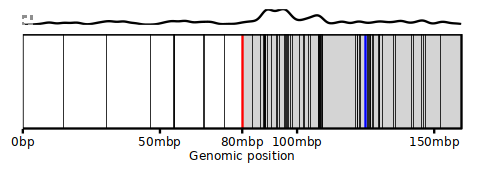

In [31]:
options(repr.plot.width=4, repr.plot.height=1.5)
gene_density_plot / inactivated_gene_plot + plot_layout(heights=c(0.5, 3))
new_inactivated_gene_plot <- gene_density_plot / inactivated_gene_plot + plot_layout(heights=c(0.5, 3))
#upregulated_gene_plot

In [32]:
make_pdf(new_inactivated_gene_plot, "new_chr3_inactivated_gene_plot", w=4, h=1.5)

png 
  2

In [72]:
# List of protein IDs in complexes obtained from http://ftp.ebi.ac.uk/pub/databases/intact/complex/current/complextab/10090.tsv
# Protein IDs were converted to ENSEMBL gene IDs with BioMart https://nov2020.archive.ensembl.org/biomart/martview/
complex_forming_genes <- c("ENSMUSG00000070390","ENSMUSG00000031095","ENSMUSG00000035576","ENSMUSG00000020758","ENSMUSG00000064127","ENSMUSG00000079487","ENSMUSG00000057378","ENSMUSG00000040720","ENSMUSG00000072980","ENSMUSG00000026768","ENSMUSG00000051747","ENSMUSG00000068394","ENSMUSG00000059995","ENSMUSG00000007880","ENSMUSG00000039219","ENSMUSG00000010453","ENSMUSG00000033769","ENSMUSG00000041445","ENSMUSG00000020916","ENSMUSG00000024897","ENSMUSG00000038102","ENSMUSG00000069272","ENSMUSG00000071478","ENSMUSG00000069270","ENSMUSG00000071516","ENSMUSG00000061615","ENSMUSG00000069309","ENSMUSG00000094248","ENSMUSG00000094777","ENSMUSG00000069301","ENSMUSG00000038770","ENSMUSG00000021057","ENSMUSG00000028001","ENSMUSG00000024169","ENSMUSG00000030592","ENSMUSG00000071226","ENSMUSG00000021313","ENSMUSG00000022000","ENSMUSG00000033237","ENSMUSG00000074818","ENSMUSG00000006005","ENSMUSG00000048118","ENSMUSG00000054051","ENSMUSG00000070808","ENSMUSG00000026509","ENSMUSG00000024381","ENSMUSG00000013663","ENSMUSG00000030814","ENSMUSG00000063727","ENSMUSG00000057789","ENSMUSG00000022324","ENSMUSG00000029238","ENSMUSG00000032855","ENSMUSG00000028249","ENSMUSG00000028800","ENSMUSG00000031059","ENSMUSG00000020668","ENSMUSG00000004264","ENSMUSG00000031921","ENSMUSG00000028339","ENSMUSG00000029177","ENSMUSG00000034462","ENSMUSG00000020792","ENSMUSG00000027782","ENSMUSG00000021929","ENSMUSG00000003731","ENSMUSG00000024942","ENSMUSG00000029763","ENSMUSG00000028926","ENSMUSG00000029469","ENSMUSG00000009090","ENSMUSG00000020471","ENSMUSG00000045948","ENSMUSG00000016427","ENSMUSG00000020583","ENSMUSG00000090071","ENSMUSG00000050675","ENSMUSG00000059363","ENSMUSG00000037772","ENSMUSG00000020893","ENSMUSG00000030165","ENSMUSG00000028757","ENSMUSG00000020198","ENSMUSG00000039231","ENSMUSG00000020689","ENSMUSG00000022809","ENSMUSG00000027381","ENSMUSG00000037935","ENSMUSG00000067713","ENSMUSG00000020974","ENSMUSG00000028847","ENSMUSG00000090247","ENSMUSG00000060636","ENSMUSG00000020897","ENSMUSG00000002814","ENSMUSG00000017716","ENSMUSG00000016758","ENSMUSG00000028957","ENSMUSG00000021611","ENSMUSG00000031819","ENSMUSG00000026196","ENSMUSG00000007877","ENSMUSG00000020722","ENSMUSG00000031012","ENSMUSG00000030054","ENSMUSG00000026837","ENSMUSG00000035021","ENSMUSG00000013415","ENSMUSG00000027012","ENSMUSG00000004221","ENSMUSG00000024947","ENSMUSG00000106695","ENSMUSG00000000142","ENSMUSG00000031609","ENSMUSG00000035086","ENSMUSG00000091512","ENSMUSG00000031660","ENSMUSG00000030528","ENSMUSG00000020331","ENSMUSG00000021730","ENSMUSG00000028051","ENSMUSG00000026761","ENSMUSG00000045867","ENSMUSG00000019979","ENSMUSG00000003872","ENSMUSG00000027162","ENSMUSG00000026029","ENSMUSG00000064370","ENSMUSG00000021250","ENSMUSG00000022346","ENSMUSG00000053977","ENSMUSG00000031502","ENSMUSG00000002900","ENSMUSG00000064341","ENSMUSG00000064345","ENSMUSG00000064360","ENSMUSG00000065947","ENSMUSG00000064363","ENSMUSG00000064367","ENSMUSG00000064368","ENSMUSG00000046834","ENSMUSG00000052217","ENSMUSG00000024620","ENSMUSG00000052684","ENSMUSG00000023043","ENSMUSG00000055609","ENSMUSG00000021822","ENSMUSG00000019982","ENSMUSG00000032231","ENSMUSG00000030978","ENSMUSG00000021270","ENSMUSG00000003549","ENSMUSG00000026043","ENSMUSG00000031503","ENSMUSG00000041959","ENSMUSG00000022982","ENSMUSG00000025809","ENSMUSG00000025371","ENSMUSG00000037894","ENSMUSG00000024109","ENSMUSG00000113902","ENSMUSG00000053044","ENSMUSG00000057329","ENSMUSG00000005397","ENSMUSG00000021939","ENSMUSG00000022884","ENSMUSG00000069268","ENSMUSG00000094338","ENSMUSG00000095217","ENSMUSG00000069307","ENSMUSG00000069303","ENSMUSG00000069300","ENSMUSG00000001506","ENSMUSG00000020649","ENSMUSG00000031538","ENSMUSG00000037992","ENSMUSG00000019942","ENSMUSG00000023944","ENSMUSG00000049382","ENSMUSG00000001128","ENSMUSG00000000555","ENSMUSG00000020277","ENSMUSG00000062647","ENSMUSG00000022105","ENSMUSG00000026576","ENSMUSG00000036905","ENSMUSG00000046364","ENSMUSG00000037563","ENSMUSG00000043716","ENSMUSG00000032518","ENSMUSG00000067274","ENSMUSG00000071076","ENSMUSG00000110974","ENSMUSG00000068220","ENSMUSG00000020428","ENSMUSG00000060279","ENSMUSG00000002957","ENSMUSG00000028645","ENSMUSG00000027342","ENSMUSG00000027931","ENSMUSG00000020592","ENSMUSG00000091898","ENSMUSG00000032796","ENSMUSG00000074129","ENSMUSG00000021665","ENSMUSG00000025395","ENSMUSG00000015290","ENSMUSG00000020436","ENSMUSG00000031731","ENSMUSG00000029054","ENSMUSG00000039639","ENSMUSG00000023994","ENSMUSG00000115906","ENSMUSG00000030830","ENSMUSG00000027187","ENSMUSG00000041431","ENSMUSG00000041859","ENSMUSG00000056174","ENSMUSG00000070348","ENSMUSG00000044533","ENSMUSG00000001281","ENSMUSG00000000560","ENSMUSG00000031343","ENSMUSG00000030435","ENSMUSG00000029231","ENSMUSG00000056054","ENSMUSG00000026187","ENSMUSG00000060036","ENSMUSG00000027248","ENSMUSG00000027985","ENSMUSG00000056501","ENSMUSG00000022483","ENSMUSG00000059436","ENSMUSG00000015846","ENSMUSG00000039656","ENSMUSG00000018395","ENSMUSG00000014767","ENSMUSG00000022283","ENSMUSG00000025232","ENSMUSG00000025888","ENSMUSG00000020826","ENSMUSG00000029863","ENSMUSG00000017344","ENSMUSG00000032218","ENSMUSG00000000184","ENSMUSG00000034165","ENSMUSG00000006728","ENSMUSG00000056071","ENSMUSG00000006678","ENSMUSG00000026134","ENSMUSG00000024833","ENSMUSG00000059003","ENSMUSG00000026959","ENSMUSG00000046223","ENSMUSG00000031299","ENSMUSG00000041695","ENSMUSG00000003033","ENSMUSG00000025408","ENSMUSG00000032193","ENSMUSG00000038900","ENSMUSG00000059070","ENSMUSG00000021779","ENSMUSG00000001435","ENSMUSG00000030432","ENSMUSG00000015579","ENSMUSG00000024151","ENSMUSG00000027087","ENSMUSG00000022391","ENSMUSG00000009907","ENSMUSG00000031201","ENSMUSG00000053110","ENSMUSG00000032116","ENSMUSG00000032553","ENSMUSG00000025407","ENSMUSG00000033065","ENSMUSG00000029614","ENSMUSG00000048758","ENSMUSG00000007892","ENSMUSG00000058558","ENSMUSG00000000740","ENSMUSG00000022479","ENSMUSG00000070880","ENSMUSG00000026787","ENSMUSG00000021816","ENSMUSG00000022092","ENSMUSG00000032034","ENSMUSG00000017146","ENSMUSG00000035458","ENSMUSG00000029253","ENSMUSG00000028969","ENSMUSG00000022673","ENSMUSG00000005410","ENSMUSG00000026414","ENSMUSG00000031449","ENSMUSG00000047215","ENSMUSG00000092074","ENSMUSG00000096255","ENSMUSG00000000579","ENSMUSG00000095677","ENSMUSG00000040613","ENSMUSG00000040533","ENSMUSG00000027715","ENSMUSG00000021103","ENSMUSG00000066878","ENSMUSG00000018362","ENSMUSG00000038644","ENSMUSG00000021606","ENSMUSG00000034957","ENSMUSG00000038975","ENSMUSG00000005370","ENSMUSG00000050761","ENSMUSG00000034362","ENSMUSG00000018983","ENSMUSG00000017264","ENSMUSG00000003458","ENSMUSG00000054312","ENSMUSG00000039680","ENSMUSG00000021221","ENSMUSG00000036678","ENSMUSG00000040034","ENSMUSG00000116037","ENSMUSG00000014418","ENSMUSG00000042548","ENSMUSG00000030079","ENSMUSG00000039703","ENSMUSG00000029580","ENSMUSG00000062270","ENSMUSG00000059796","ENSMUSG00000028234","ENSMUSG00000038583","ENSMUSG00000074781","ENSMUSG00000036372","ENSMUSG00000048100","ENSMUSG00000060938","ENSMUSG00000028609","ENSMUSG00000063316","ENSMUSG00000046330","ENSMUSG00000022174","ENSMUSG00000048895","ENSMUSG00000026917","ENSMUSG00000004849","ENSMUSG00000061477","ENSMUSG00000047675","ENSMUSG00000008683","ENSMUSG00000024608","ENSMUSG00000049517","ENSMUSG00000008668","ENSMUSG00000034892","ENSMUSG00000003429","ENSMUSG00000090862","ENSMUSG00000047459","ENSMUSG00000031320","ENSMUSG00000045128","ENSMUSG00000008036","ENSMUSG00000058546","ENSMUSG00000028495","ENSMUSG00000091405","ENSMUSG00000060981","ENSMUSG00000069274","ENSMUSG00000061482","ENSMUSG00000060678","ENSMUSG00000067455","ENSMUSG00000064288","ENSMUSG00000069266","ENSMUSG00000060093","ENSMUSG00000069306","ENSMUSG00000069305","ENSMUSG00000060639","ENSMUSG00000096010","ENSMUSG00000010803","ENSMUSG00000071415","ENSMUSG00000063457","ENSMUSG00000025290","ENSMUSG00000009927","ENSMUSG00000025362","ENSMUSG00000067288","ENSMUSG00000022400","ENSMUSG00000058600","ENSMUSG00000079641","ENSMUSG00000063694","ENSMUSG00000058927","ENSMUSG00000073702","ENSMUSG00000030744","ENSMUSG00000057841","ENSMUSG00000003970","ENSMUSG00000093674","ENSMUSG00000028639","ENSMUSG00000020460","ENSMUSG00000068240","ENSMUSG00000090137","ENSMUSG00000015656","ENSMUSG00000028156","ENSMUSG00000033676","ENSMUSG00000022285","ENSMUSG00000007653","ENSMUSG00000020248","ENSMUSG00000009013","ENSMUSG00000026824","ENSMUSG00000061787","ENSMUSG00000015120","ENSMUSG00000052146","ENSMUSG00000028161","ENSMUSG00000038845","ENSMUSG00000099517","ENSMUSG00000101355","ENSMUSG00000069265","ENSMUSG00000101972","ENSMUSG00000001440","ENSMUSG00000026585","ENSMUSG00000025271","ENSMUSG00000067199","ENSMUSG00000031681","ENSMUSG00000089682","ENSMUSG00000032897","ENSMUSG00000005262","ENSMUSG00000020647","ENSMUSG00000025925","ENSMUSG00000002010","ENSMUSG00000004446","ENSMUSG00000023027","ENSMUSG00000049751","ENSMUSG00000079435","ENSMUSG00000022841","ENSMUSG00000017404","ENSMUSG00000081058","ENSMUSG00000093769","ENSMUSG00000074403","ENSMUSG00000100210","ENSMUSG00000069273","ENSMUSG00000099583","ENSMUSG00000069310","ENSMUSG00000069267","ENSMUSG00000060499","ENSMUSG00000038612","ENSMUSG00000002870","ENSMUSG00000026355","ENSMUSG00000022672","ENSMUSG00000028081","ENSMUSG00000025358","ENSMUSG00000009545","ENSMUSG00000004642","ENSMUSG00000030697","ENSMUSG00000024515","ENSMUSG00000023051","ENSMUSG00000030652","ENSMUSG00000032481","ENSMUSG00000020038","ENSMUSG00000067614","ENSMUSG00000019846","ENSMUSG00000041147","ENSMUSG00000036887","ENSMUSG00000025508","ENSMUSG00000063882","ENSMUSG00000023951","ENSMUSG00000068196","ENSMUSG00000021264","ENSMUSG00000020734","ENSMUSG00000025958","ENSMUSG00000029661","ENSMUSG00000051331","ENSMUSG00000028452","ENSMUSG00000036896","ENSMUSG00000006932","ENSMUSG00000020241","ENSMUSG00000069089","ENSMUSG00000023885","ENSMUSG00000002771","ENSMUSG00000059412","ENSMUSG00000001119","ENSMUSG00000039462","ENSMUSG00000028047","ENSMUSG00000060798","ENSMUSG00000116357","ENSMUSG00000042406","ENSMUSG00000025064","ENSMUSG00000003873","ENSMUSG00000027323","ENSMUSG00000038482","ENSMUSG00000027067","ENSMUSG00000116526","ENSMUSG00000034848","ENSMUSG00000025321","ENSMUSG00000037185","ENSMUSG00000026141","ENSMUSG00000048402","ENSMUSG00000034292","ENSMUSG00000003119","ENSMUSG00000063884","ENSMUSG00000069830","ENSMUSG00000057177","ENSMUSG00000026609","ENSMUSG00000068794","ENSMUSG00000040187","ENSMUSG00000028863","ENSMUSG00000028197","ENSMUSG00000024687","ENSMUSG00000049562","ENSMUSG00000008140","ENSMUSG00000024349","ENSMUSG00000001445","ENSMUSG00000031446","ENSMUSG00000002658","ENSMUSG00000041126","ENSMUSG00000021711","ENSMUSG00000036672","ENSMUSG00000032187","ENSMUSG00000061244","ENSMUSG00000041215","ENSMUSG00000038544","ENSMUSG00000047921","ENSMUSG00000006335","ENSMUSG00000024740","ENSMUSG00000012076","ENSMUSG00000026708","ENSMUSG00000039623","ENSMUSG00000026042","ENSMUSG00000005233","ENSMUSG00000020743","ENSMUSG00000042015","ENSMUSG00000041471","ENSMUSG00000073471","ENSMUSG00000037890","ENSMUSG00000031820","ENSMUSG00000028114","ENSMUSG00000071014","ENSMUSG00000049323","ENSMUSG00000034560","ENSMUSG00000033862","ENSMUSG00000037991","ENSMUSG00000057649","ENSMUSG00000047146","ENSMUSG00000075266","ENSMUSG00000025645","ENSMUSG00000011658","ENSMUSG00000028330","ENSMUSG00000070369","ENSMUSG00000006464","ENSMUSG00000042284","ENSMUSG00000027829","ENSMUSG00000064128","ENSMUSG00000073436","ENSMUSG00000042506","ENSMUSG00000038000","ENSMUSG00000050697","ENSMUSG00000025782","ENSMUSG00000022191","ENSMUSG00000049299","ENSMUSG00000044795","ENSMUSG00000045672","ENSMUSG00000020519","ENSMUSG00000020898","ENSMUSG00000038909","ENSMUSG00000034297","ENSMUSG00000034329","ENSMUSG00000057667","ENSMUSG00000052595","ENSMUSG00000042557","ENSMUSG00000027544","ENSMUSG00000060601","ENSMUSG00000000568","ENSMUSG00000019899","ENSMUSG00000005947","ENSMUSG00000023964","ENSMUSG00000042453","ENSMUSG00000032332","ENSMUSG00000021408","ENSMUSG00000026037","ENSMUSG00000022905","ENSMUSG00000057236","ENSMUSG00000031353","ENSMUSG00000015647","ENSMUSG00000001105","ENSMUSG00000005886","ENSMUSG00000026641","ENSMUSG00000019471","ENSMUSG00000026639","ENSMUSG00000024826","ENSMUSG00000031077","ENSMUSG00000031386","ENSMUSG00000031928","ENSMUSG00000015994","ENSMUSG00000027966","ENSMUSG00000052911","ENSMUSG00000024959","ENSMUSG00000025499","ENSMUSG00000027793","ENSMUSG00000002068","ENSMUSG00000021548","ENSMUSG00000023018","ENSMUSG00000027490","ENSMUSG00000021318","ENSMUSG00000031533","ENSMUSG00000027111","ENSMUSG00000096146","ENSMUSG00000027475","ENSMUSG00000045545","ENSMUSG00000029730","ENSMUSG00000031622","ENSMUSG00000024241","ENSMUSG00000015776","ENSMUSG00000037013","ENSMUSG00000036980","ENSMUSG00000032440","ENSMUSG00000026374","ENSMUSG00000024563","ENSMUSG00000028252","ENSMUSG00000015533","ENSMUSG00000001507","ENSMUSG00000008958","ENSMUSG00000017858","ENSMUSG00000033953","ENSMUSG00000028310","ENSMUSG00000109511","ENSMUSG00000025650","ENSMUSG00000024949","ENSMUSG00000106722","ENSMUSG00000040274","ENSMUSG00000025758","ENSMUSG00000116326","ENSMUSG00000058239","ENSMUSG00000007613","ENSMUSG00000024330","ENSMUSG00000027326","ENSMUSG00000040865","ENSMUSG00000041297","ENSMUSG00000066415","ENSMUSG00000023932","ENSMUSG00000042029","ENSMUSG00000025648","ENSMUSG00000037315","ENSMUSG00000039068","ENSMUSG00000034152","ENSMUSG00000047767","ENSMUSG00000030323","ENSMUSG00000045983","ENSMUSG00000039738","ENSMUSG00000041846","ENSMUSG00000059474","ENSMUSG00000028949","ENSMUSG00000038205","ENSMUSG00000002428","ENSMUSG00000025369","ENSMUSG00000035770","ENSMUSG00000052915","ENSMUSG00000063870","ENSMUSG00000028294","ENSMUSG00000022292","ENSMUSG00000033628","ENSMUSG00000031099","ENSMUSG00000074030","ENSMUSG00000024104","ENSMUSG00000042185","ENSMUSG00000050310","ENSMUSG00000000600","ENSMUSG00000038564","ENSMUSG00000025764","ENSMUSG00000034154","ENSMUSG00000032555","ENSMUSG00000020387","ENSMUSG00000052533","ENSMUSG00000048578","ENSMUSG00000006333","ENSMUSG00000058443","ENSMUSG00000008682","ENSMUSG00000062997","ENSMUSG00000078193","ENSMUSG00000041084","ENSMUSG00000002043","ENSMUSG00000020022","ENSMUSG00000032423","ENSMUSG00000045248","ENSMUSG00000054702","ENSMUSG00000021377","ENSMUSG00000027933","ENSMUSG00000040463","ENSMUSG00000028322","ENSMUSG00000027751","ENSMUSG00000039809","ENSMUSG00000018412","ENSMUSG00000001855","ENSMUSG00000027959","ENSMUSG00000031314","ENSMUSG00000001998","ENSMUSG00000066621","ENSMUSG00000039137","ENSMUSG00000055334","ENSMUSG00000044254","ENSMUSG00000047534","ENSMUSG00000022371","ENSMUSG00000046756","ENSMUSG00000055553","ENSMUSG00000030708","ENSMUSG00000021559","ENSMUSG00000041238","ENSMUSG00000028364","ENSMUSG00000026725","ENSMUSG00000033543","ENSMUSG00000037740","ENSMUSG00000021932","ENSMUSG00000035919","ENSMUSG00000036106","ENSMUSG00000026798","ENSMUSG00000006542","ENSMUSG00000024286","ENSMUSG00000026107","ENSMUSG00000029656","ENSMUSG00000052798","ENSMUSG00000047989","ENSMUSG00000055078","ENSMUSG00000028873","ENSMUSG00000024260","ENSMUSG00000036291","ENSMUSG00000032939","ENSMUSG00000004843","ENSMUSG00000039055","ENSMUSG00000024038","ENSMUSG00000024576","ENSMUSG00000041632","ENSMUSG00000028576","ENSMUSG00000038696","ENSMUSG00000038116","ENSMUSG00000040690","ENSMUSG00000074811","ENSMUSG00000025646","ENSMUSG00000028247","ENSMUSG00000066643","ENSMUSG00000098274","ENSMUSG00000035234","ENSMUSG00000022992","ENSMUSG00000066900","ENSMUSG00000021767","ENSMUSG00000028518","ENSMUSG00000056832","ENSMUSG00000008690","ENSMUSG00000042323","ENSMUSG00000063801","ENSMUSG00000031328","ENSMUSG00000034826","ENSMUSG00000109941","ENSMUSG00000020514","ENSMUSG00000032402","ENSMUSG00000024477","ENSMUSG00000015750","ENSMUSG00000038481","ENSMUSG00000024360","ENSMUSG00000032965","ENSMUSG00000015829","ENSMUSG00000039552","ENSMUSG00000020783","ENSMUSG00000030330","ENSMUSG00000069495","ENSMUSG00000026289","ENSMUSG00000032396","ENSMUSG00000021209","ENSMUSG00000034906","ENSMUSG00000027080","ENSMUSG00000025235","ENSMUSG00000021965","ENSMUSG00000022350","ENSMUSG00000020319","ENSMUSG00000031629","ENSMUSG00000025144","ENSMUSG00000027509","ENSMUSG00000032375","ENSMUSG00000078517","ENSMUSG00000039985","ENSMUSG00000024240","ENSMUSG00000057914","ENSMUSG00000037526","ENSMUSG00000046192","ENSMUSG00000040866","ENSMUSG00000040667","ENSMUSG00000050552","ENSMUSG00000034349","ENSMUSG00000028312","ENSMUSG00000034160","ENSMUSG00000036568","ENSMUSG00000029505","ENSMUSG00000024926","ENSMUSG00000018651","ENSMUSG00000036180","ENSMUSG00000028019","ENSMUSG00000027425","ENSMUSG00000026491","ENSMUSG00000036698","ENSMUSG00000019906","ENSMUSG00000020652","ENSMUSG00000047604","ENSMUSG00000027778","ENSMUSG00000033831","ENSMUSG00000043866","ENSMUSG00000035031","ENSMUSG00000031262","ENSMUSG00000031782","ENSMUSG00000046573","ENSMUSG00000035354","ENSMUSG00000061273","ENSMUSG00000021577","ENSMUSG00000037325","ENSMUSG00000033373","ENSMUSG00000020628","ENSMUSG00000020775","ENSMUSG00000042694","ENSMUSG00000037531","ENSMUSG00000000378","ENSMUSG00000059734","ENSMUSG00000052139","ENSMUSG00000078676","ENSMUSG00000053293","ENSMUSG00000024053","ENSMUSG00000021144","ENSMUSG00000063564","ENSMUSG00000049489","ENSMUSG00000038982","ENSMUSG00000018858","ENSMUSG00000062203","ENSMUSG00000067995","ENSMUSG00000039509","ENSMUSG00000048930","ENSMUSG00000059534","ENSMUSG00000021235","ENSMUSG00000034190","ENSMUSG00000003680","ENSMUSG00000016833","ENSMUSG00000031539","ENSMUSG00000015971","ENSMUSG00000079614","ENSMUSG00000025374","ENSMUSG00000019715","ENSMUSG00000033970","ENSMUSG00000059518","ENSMUSG00000114797","ENSMUSG00000063895","ENSMUSG00000003778","ENSMUSG00000029635","ENSMUSG00000014232","ENSMUSG00000036435","ENSMUSG00000020882","ENSMUSG00000020739","ENSMUSG00000032691","ENSMUSG00000021738","ENSMUSG00000026999","ENSMUSG00000039356","ENSMUSG00000028614","ENSMUSG00000002968","ENSMUSG00000031935","ENSMUSG00000015083","ENSMUSG00000033860","ENSMUSG00000061650","ENSMUSG00000035831","ENSMUSG00000032571","ENSMUSG00000021013","ENSMUSG00000024101","ENSMUSG00000033161","ENSMUSG00000044018","ENSMUSG00000023723","ENSMUSG00000098375","ENSMUSG00000025451","ENSMUSG00000028899","ENSMUSG00000027835","ENSMUSG00000060708","ENSMUSG00000031913","ENSMUSG00000039630","ENSMUSG00000111145","ENSMUSG00000029670","ENSMUSG00000069170","ENSMUSG00000042390","ENSMUSG00000052293","ENSMUSG00000078941","ENSMUSG00000024033","ENSMUSG00000027615","ENSMUSG00000025580","ENSMUSG00000025968","ENSMUSG00000004415","ENSMUSG00000037860","ENSMUSG00000033430","ENSMUSG00000068823","ENSMUSG00000029676","ENSMUSG00000013593","ENSMUSG00000028944","ENSMUSG00000038697","ENSMUSG00000029265","ENSMUSG00000057531","ENSMUSG00000037798","ENSMUSG00000027244","ENSMUSG00000030062","ENSMUSG00000037916","ENSMUSG00000024906","ENSMUSG00000031715","ENSMUSG00000015804","ENSMUSG00000002679","ENSMUSG00000034259","ENSMUSG00000029681","ENSMUSG00000033732","ENSMUSG00000028622","ENSMUSG00000000743","ENSMUSG00000020463","ENSMUSG00000061527","ENSMUSG00000027998","ENSMUSG00000078348","ENSMUSG00000020063","ENSMUSG00000016356","ENSMUSG00000012114","ENSMUSG00000055817","ENSMUSG00000035772","ENSMUSG00000032006","ENSMUSG00000018160","ENSMUSG00000020358","ENSMUSG00000000561","ENSMUSG00000022881","ENSMUSG00000002109","ENSMUSG00000038160","ENSMUSG00000009555","ENSMUSG00000021278","ENSMUSG00000078619","ENSMUSG00000024218","ENSMUSG00000063887","ENSMUSG00000029163","ENSMUSG00000017210","ENSMUSG00000042328","ENSMUSG00000030286","ENSMUSG00000024735","ENSMUSG00000037570","ENSMUSG00000026260","ENSMUSG00000032314","ENSMUSG00000026563","ENSMUSG00000021028","ENSMUSG00000109901","ENSMUSG00000038803","ENSMUSG00000028648","ENSMUSG00000031546","ENSMUSG00000049548","ENSMUSG00000035984","ENSMUSG00000002083","ENSMUSG00000029712","ENSMUSG00000080268","ENSMUSG00000024436","ENSMUSG00000027374","ENSMUSG00000021607","ENSMUSG00000034880","ENSMUSG00000024414","ENSMUSG00000024683","ENSMUSG00000028140","ENSMUSG00000032563","ENSMUSG00000029486","ENSMUSG00000026683","ENSMUSG00000022142","ENSMUSG00000020962","ENSMUSG00000030034","ENSMUSG00000021901","ENSMUSG00000023089","ENSMUSG00000023919","ENSMUSG00000033845","ENSMUSG00000002416","ENSMUSG00000062981","ENSMUSG00000028066","ENSMUSG00000079677","ENSMUSG00000034932","ENSMUSG00000049960","ENSMUSG00000020163","ENSMUSG00000030335","ENSMUSG00000019710","ENSMUSG00000053119","ENSMUSG00000024925","ENSMUSG00000030842","ENSMUSG00000030042","ENSMUSG00000030291","ENSMUSG00000007338","ENSMUSG00000022774","ENSMUSG00000030647","ENSMUSG00000044894","ENSMUSG00000014294","ENSMUSG00000028549","ENSMUSG00000115904","ENSMUSG00000035674","ENSMUSG00000068101","ENSMUSG00000040236","ENSMUSG00000009863","ENSMUSG00000022109","ENSMUSG00000063787","ENSMUSG00000022820","ENSMUSG00000031242","ENSMUSG00000034211","ENSMUSG00000024902","ENSMUSG00000021967","ENSMUSG00000027673","ENSMUSG00000038622","ENSMUSG00000022354","ENSMUSG00000029066","ENSMUSG00000057388","ENSMUSG00000052962","ENSMUSG00000036850","ENSMUSG00000106918","ENSMUSG00000079317","ENSMUSG00000039001","ENSMUSG00000036835","ENSMUSG00000027133","ENSMUSG00000019923","ENSMUSG00000020477","ENSMUSG00000047260","ENSMUSG00000043501","ENSMUSG00000032905","ENSMUSG00000031232","ENSMUSG00000037152","ENSMUSG00000022450","ENSMUSG00000026032","ENSMUSG00000020171","ENSMUSG00000030869","ENSMUSG00000020056","ENSMUSG00000020492","ENSMUSG00000025794","ENSMUSG00000033751","ENSMUSG00000033938","ENSMUSG00000058267","ENSMUSG00000061286","ENSMUSG00000001056","ENSMUSG00000062376","ENSMUSG00000022337","ENSMUSG00000033166","ENSMUSG00000031755","ENSMUSG00000057506","ENSMUSG00000027649","ENSMUSG00000024854","ENSMUSG00000097508","ENSMUSG00000035351","ENSMUSG00000052926","ENSMUSG00000038374","ENSMUSG00000029438","ENSMUSG00000041733","ENSMUSG00000028973","ENSMUSG00000021598","ENSMUSG00000020801","ENSMUSG00000000171","ENSMUSG00000032459","ENSMUSG00000059291","ENSMUSG00000075273","ENSMUSG00000040269","ENSMUSG00000040599","ENSMUSG00000028010","ENSMUSG00000026248","ENSMUSG00000031669","ENSMUSG00000027635","ENSMUSG00000025651","ENSMUSG00000107235","ENSMUSG00000027454","ENSMUSG00000027455","ENSMUSG00000066042","ENSMUSG00000036860","ENSMUSG00000021391","ENSMUSG00000058076","ENSMUSG00000020397","ENSMUSG00000022978","ENSMUSG00000012405","ENSMUSG00000063145","ENSMUSG00000118537","ENSMUSG00000053134","ENSMUSG00000031756","ENSMUSG00000040952","ENSMUSG00000027131","ENSMUSG00000078923","ENSMUSG00000021748","ENSMUSG00000074476","ENSMUSG00000073705","ENSMUSG00000024056","ENSMUSG00000029363","ENSMUSG00000021731","ENSMUSG00000025785","ENSMUSG00000022551","ENSMUSG00000020483","ENSMUSG00000022945","ENSMUSG00000016637","ENSMUSG00000018882","ENSMUSG00000010406","ENSMUSG00000044991","ENSMUSG00000014551","ENSMUSG00000024181","ENSMUSG00000025858","ENSMUSG00000030037","ENSMUSG00000023939","ENSMUSG00000087260","ENSMUSG00000030298","ENSMUSG00000024829","ENSMUSG00000022370","ENSMUSG00000030801","ENSMUSG00000062006","ENSMUSG00000005687","ENSMUSG00000020993","ENSMUSG00000022674","ENSMUSG00000029918","ENSMUSG00000030045","ENSMUSG00000009070","ENSMUSG00000035367","ENSMUSG00000021357","ENSMUSG00000031821","ENSMUSG00000029211","ENSMUSG00000063172","ENSMUSG00000025204","ENSMUSG00000024099","ENSMUSG00000032279","ENSMUSG00000045176","ENSMUSG00000002345","ENSMUSG00000068264","ENSMUSG00000029003","ENSMUSG00000027752","ENSMUSG00000002767","ENSMUSG00000027536","ENSMUSG00000020778","ENSMUSG00000060679","ENSMUSG00000026087","ENSMUSG00000025825","ENSMUSG00000028419","ENSMUSG00000006392","ENSMUSG00000041841","ENSMUSG00000038467","ENSMUSG00000018923","ENSMUSG00000032399","ENSMUSG00000030879","ENSMUSG00000026283","ENSMUSG00000037204","ENSMUSG00000042992","ENSMUSG00000021790","ENSMUSG00000023966","ENSMUSG00000030714","ENSMUSG00000007867","ENSMUSG00000023806","ENSMUSG00000034321","ENSMUSG00000007987","ENSMUSG00000027569","ENSMUSG00000002031","ENSMUSG00000039640","ENSMUSG00000033916","ENSMUSG00000026799","ENSMUSG00000031367","ENSMUSG00000022217","ENSMUSG00000030884","ENSMUSG00000030888","ENSMUSG00000003444","ENSMUSG00000035152","ENSMUSG00000027642","ENSMUSG00000032042","ENSMUSG00000000399","ENSMUSG00000020153","ENSMUSG00000028861","ENSMUSG00000015672","ENSMUSG00000024142","ENSMUSG00000026895","ENSMUSG00000065990","ENSMUSG00000024480","ENSMUSG00000040048","ENSMUSG00000005510","ENSMUSG00000111727","ENSMUSG00000003299","ENSMUSG00000004610","ENSMUSG00000055943","ENSMUSG00000030793","ENSMUSG00000022236","ENSMUSG00000023980","ENSMUSG00000030612","ENSMUSG00000022718","ENSMUSG00000106687","ENSMUSG00000060475","ENSMUSG00000068921","ENSMUSG00000036199","ENSMUSG00000003226","ENSMUSG00000025507","ENSMUSG00000032112","ENSMUSG00000063049","ENSMUSG00000025907","ENSMUSG00000021714","ENSMUSG00000031403","ENSMUSG00000000708","ENSMUSG00000020918","ENSMUSG00000027714","ENSMUSG00000008590","ENSMUSG00000040472","ENSMUSG00000028062","ENSMUSG00000004096","ENSMUSG00000018707","ENSMUSG00000009640","ENSMUSG00000016619","ENSMUSG00000020075","ENSMUSG00000038880","ENSMUSG00000022338","ENSMUSG00000020659","ENSMUSG00000022534","ENSMUSG00000053519","ENSMUSG00000006398","ENSMUSG00000025221","ENSMUSG00000029068","ENSMUSG00000057322","ENSMUSG00000028988","ENSMUSG00000040044","ENSMUSG00000019518","ENSMUSG00000021824","ENSMUSG00000022889","ENSMUSG00000068391","ENSMUSG00000026726","ENSMUSG00000028991","ENSMUSG00000024521","ENSMUSG00000062444","ENSMUSG00000015013","ENSMUSG00000034664","ENSMUSG00000002835","ENSMUSG00000011960","ENSMUSG00000030584","ENSMUSG00000030789","ENSMUSG00000045969","ENSMUSG00000030091","ENSMUSG00000045273","ENSMUSG00000022545","ENSMUSG00000056820","ENSMUSG00000020718","ENSMUSG00000067158","ENSMUSG00000079465","ENSMUSG00000029513","ENSMUSG00000026840","ENSMUSG00000005804","ENSMUSG00000031849","ENSMUSG00000051879","ENSMUSG00000031422","ENSMUSG00000092558","ENSMUSG00000032175","ENSMUSG00000071646","ENSMUSG00000068742","ENSMUSG00000051316","ENSMUSG00000058806","ENSMUSG00000052833","ENSMUSG00000059588","ENSMUSG00000028224","ENSMUSG00000024308","ENSMUSG00000034353","ENSMUSG00000055116","ENSMUSG00000003868","ENSMUSG00000002731","ENSMUSG00000029554","ENSMUSG00000030873","ENSMUSG00000000216","ENSMUSG00000024660","ENSMUSG00000032504","ENSMUSG00000021196","ENSMUSG00000023104","ENSMUSG00000001240","ENSMUSG00000041046","ENSMUSG00000018189","ENSMUSG00000029012","ENSMUSG00000024462","ENSMUSG00000024091","ENSMUSG00000022812","ENSMUSG00000032952","ENSMUSG00000066979","ENSMUSG00000007080","ENSMUSG00000031358","ENSMUSG00000048756","ENSMUSG00000020955","ENSMUSG00000000902","ENSMUSG00000025231","ENSMUSG00000026971","ENSMUSG00000040896","ENSMUSG00000060882","ENSMUSG00000051329","ENSMUSG00000002108","ENSMUSG00000029910","ENSMUSG00000052997","ENSMUSG00000027618","ENSMUSG00000028587","ENSMUSG00000041881","ENSMUSG00000024392","ENSMUSG00000040084","ENSMUSG00000021686","ENSMUSG00000021702","ENSMUSG00000000028","ENSMUSG00000028212","ENSMUSG00000001018","ENSMUSG00000002748","ENSMUSG00000035478","ENSMUSG00000024513","ENSMUSG00000027671","ENSMUSG00000022706","ENSMUSG00000022779")

# List of proteins in condensates obtained from https://cd-code.org/condensates
condensate_genes <- c("ENSMUSG00000028156","ENSMUSG00000042766","ENSMUSG00000025757","ENSMUSG00000027804","ENSMUSG00000068798","ENSMUSG00000040724","ENSMUSG00000033900","ENSMUSG00000000563","ENSMUSG00000027680","ENSMUSG00000004892","ENSMUSG00000038486","ENSMUSG00000002233","ENSMUSG00000027810","ENSMUSG00000015747","ENSMUSG00000027797","ENSMUSG00000000001","ENSMUSG00000070372","ENSMUSG00000053769","ENSMUSG00000036894","ENSMUSG00000027709","ENSMUSG00000047959","ENSMUSG00000040037","ENSMUSG00000034139","ENSMUSG00000053398","ENSMUSG00000027879","ENSMUSG00000027944","ENSMUSG00000027889","ENSMUSG00000052539","ENSMUSG00000027893","ENSMUSG00000028127","ENSMUSG00000027965","ENSMUSG00000027940","ENSMUSG00000037643","ENSMUSG00000027827","ENSMUSG00000028176","ENSMUSG00000028184","ENSMUSG00000027528","ENSMUSG00000033161","ENSMUSG00000027737","ENSMUSG00000045092","ENSMUSG00000041912","ENSMUSG00000028136","ENSMUSG00000062232","ENSMUSG00000068923","ENSMUSG00000027669","ENSMUSG00000090733","ENSMUSG00000027828","ENSMUSG00000027778","ENSMUSG00000062006","ENSMUSG00000039735","ENSMUSG00000028005","ENSMUSG00000044667","ENSMUSG00000047213","ENSMUSG00000069094","ENSMUSG00000049100","ENSMUSG00000033981","ENSMUSG00000028035","ENSMUSG00000038374","ENSMUSG00000001416","ENSMUSG00000032826","ENSMUSG00000028059","ENSMUSG00000043542","ENSMUSG00000005034","ENSMUSG00000025758","ENSMUSG00000027719","ENSMUSG00000045031","ENSMUSG00000028078","ENSMUSG00000064068","ENSMUSG00000040389","ENSMUSG00000028194","ENSMUSG00000027679","ENSMUSG00000028149","ENSMUSG00000027993","ENSMUSG00000053819","ENSMUSG00000027799","ENSMUSG00000040374","ENSMUSG00000028161","ENSMUSG00000027508")


In [ ]:
options(repr.plot.width=1.5, repr.plot.height=2.5)
complex <- enrichment(c(table(upregulated_genes$GENEID %in% complex_forming_genes)[[2]], 
  length(upregulated_genes$GENEID)-table(upregulated_genes$GENEID %in% complex_forming_genes)[[2]],
  table(not_upregulated %in% complex_forming_genes)[[2]],
  length(not_upregulated)-table(not_upregulated %in% complex_forming_genes)[[2]]))
complex_plot <- enrichment_barplot(complex[[3]], "Genes encoding proteins\nin complexes", 15)

condensate <- enrichment(c(table(upregulated_genes$GENEID %in% condensate_genes)[[2]], 
  length(upregulated_genes$GENEID)-table(upregulated_genes$GENEID %in% condensate_genes)[[2]],
  table(not_upregulated %in% condensate_genes)[[2]],
  length(not_upregulated)-table(not_upregulated %in% condensate_genes)[[2]]))
condensate_plot <- enrichment_barplot(condensate[[3]], "Genes encoding proteins\nin condensates", 15)


complex[[2]]
condensate[[2]]

complex_plot
condensate_plot

In [ ]:
make_pdf(complex_plot, "complex_plot_chr3", w=1, h=2.5)
make_pdf(condensate_plot, "condensate_plot_chr3", w=1, h=2.5)

In [87]:
xcu_gene_expression <- bulk_TPM_full %>% 
    filter(CDSCHROM=="chr3",
           Cast>quantile(bulk_TPM$Cast, c(0.1, 0.9))[[1]], 
           Mus>quantile(bulk_TPM$Mus, c(0.1, 0.9))[[1]],
           Cast<quantile(bulk_TPM$Cast, c(0.1, 0.9))[[2]], 
           Mus<quantile(bulk_TPM$Mus, c(0.1, 0.9))[[2]],
           sample == "d3_nodox") %>%
    mutate(up_or_ref=case_when(GENEID %in% upregulated_genes$GENEID ~ "UP",
                               GENEID %in% not_upregulated ~ "REF",
                               TRUE ~ "NOPE"),
           total=Cast+Mus) %>%
    filter(up_or_ref %in% c("UP", "REF")) %>%
    group_by(sample_name, up_or_ref) %>%
    summarize(meanSum=mean(total, na.rm=TRUE))
xcu_gene_expression

`summarise()` has grouped output by 'sample_name'. You can override using the `.groups` argument.


sample_name,up_or_ref,meanSum
<fct>,<chr>,<dbl>
d3_nodox_1,REF,49.01091
d3_nodox_1,UP,33.54786
d3_nodox_2,REF,52.04923
d3_nodox_2,UP,32.93903
d3_nodox_3,REF,47.85590
d3_nodox_3,UP,34.11748


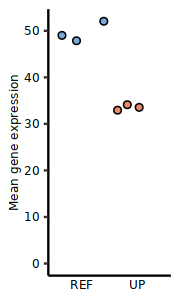

In [94]:
xcu_gene_expression_plot <- ggplot(xcu_gene_expression, aes(x=up_or_ref, y=meanSum, fill=up_or_ref)) +
    geom_jitter(height=0, shape=21) +
    ylim(0, NA) +
    ylab("Mean gene expression") +
    xlab(NULL) +
    #scale_x_discrete(labels=c("n=255", "n=255")) +
    #facet_wrap(~up_or_ref, strip.position="bottom", scales="free_x", labeller = labeller(up_or_ref=c(REF="X-linked genes", UP="Upregulated genes"))) +
    scale_fill_manual(values=c("#77AADB", "#ee8866")) +
        theme(panel.grid=element_blank(),
              panel.background=element_blank(),
              axis.title.y=element_text(color="black", size=7),
              axis.text.y=element_text(color="black", size=7),
              axis.text.x=element_text(color="black", size=7, margin=margin(t=0, b=0)),
              legend.title=element_text(size=7, hjust=0.5),
              axis.ticks=element_line(),
              axis.ticks.x=element_blank(),
              axis.line=element_line(),
              legend.text=element_text(size=7),
              legend.position="none",
              plot.title=element_text(size=7, hjust=0.5))
              #strip.background = element_blank(),
              #strip.placement = "outside",
              #strip.text.x = element_text(color="black", angle=90, size=7, hjust=1, vjust=0.5, margin=margin(t=0)),
              #panel.spacing = unit(0, "lines"))
xcu_gene_expression_plot

In [127]:
make_pdf(xcu_gene_expression_plot, "chr3_up_gene_expression_plot", w=1, h=1.5)

png 
  2

In [97]:
t.test(xcu_gene_expression[which(xcu_gene_expression$up_or_ref=="REF"),]$meanSum,
       xcu_gene_expression[which(xcu_gene_expression$up_or_ref=="UP"),]$meanSum)


	Welch Two Sample t-test

data:  xcu_gene_expression[which(xcu_gene_expression$up_or_ref == "REF"), ]$meanSum and xcu_gene_expression[which(xcu_gene_expression$up_or_ref == "UP"), ]$meanSum
t = 12.426, df = 2.2945, p-value = 0.003739
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 11.16034 21.04744
sample estimates:
mean of x mean of y 
 49.63868  33.53479 
